# 5a. Cell Population Distribution — MDE Scatter Plots

Split Control vs JARID2-CRISPRi MDE embedding, colored by sample/condition,
with trajectory arrows and cluster labels.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import TextArea, HPacker, AnchoredOffsetbox

/scratch/users/chensj16/venvs/dl2025/.venv/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Load data

In [2]:
adata_merged = sc.read_h5ad('adata_merged.250505-canonical.h5ad')

In [3]:
# Figure 1 samples (H1 differentiation series)
sample_sel1 = adata_merged.obs['sample'].isin(
    ['H1-hPSC.p6', 'H1-0.5E', 'H1-0.5ET', 'H1-0.5E4T', 'H1-E', 'H1-ET', 'H1-E4T.1']
)
adata1 = adata_merged[sample_sel1].copy()

# Figure 2 samples (Ctrl vs JARID2)
sample_sel2 = adata_merged.obs['sample'].isin(
    ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3',
     'JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']
)
adata2 = adata_merged[sample_sel2].copy()

## Color & label definitions

In [4]:
# Legend label mapping (shared labels across both panels)
legend_lut = {
    'Ctrl-hPSC.p1' : 'hPSC',
    'JARID2-hPSC'  : 'hPSC',
    'Ctrl-E.p6'    : 'Ectoderm',
    'JARID2-E'     : 'Ectoderm',
    'Ctrl-ET.p1'   : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'JARID2-ET'    : '24 h ectoderm\n\u2192 1 day of mTeSR',
    'H1-E4T.3'     : '24 h ectoderm\n\u2192 4 days of mTeSR',
    'JARID2-E4T'   : '24 h ectoderm\n\u2192 4 days of mTeSR'
}

ctrl_samples = ['Ctrl-hPSC.p1', 'Ctrl-E.p6', 'Ctrl-ET.p1', 'H1-E4T.3']
jarid2_samples = ['JARID2-hPSC', 'JARID2-E', 'JARID2-ET', 'JARID2-E4T']

ctrl_cond_colors = {
    'hPSC': '#f6c445',
    'Ectoderm': '#72a699',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#3c69c3',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#2e247e'
}

jarid2_cond_colors = {
    'hPSC': '#CE8E1B',
    'Ectoderm': '#477343',
    '24 h ectoderm\n\u2192 1 day of mTeSR': '#a1c8e7',
    '24 h ectoderm\n\u2192 4 days of mTeSR': '#78599d'
}

cond_order = list(ctrl_cond_colors.keys())

## Figure 2 — Split Control vs JARID2-CRISPRi MDE

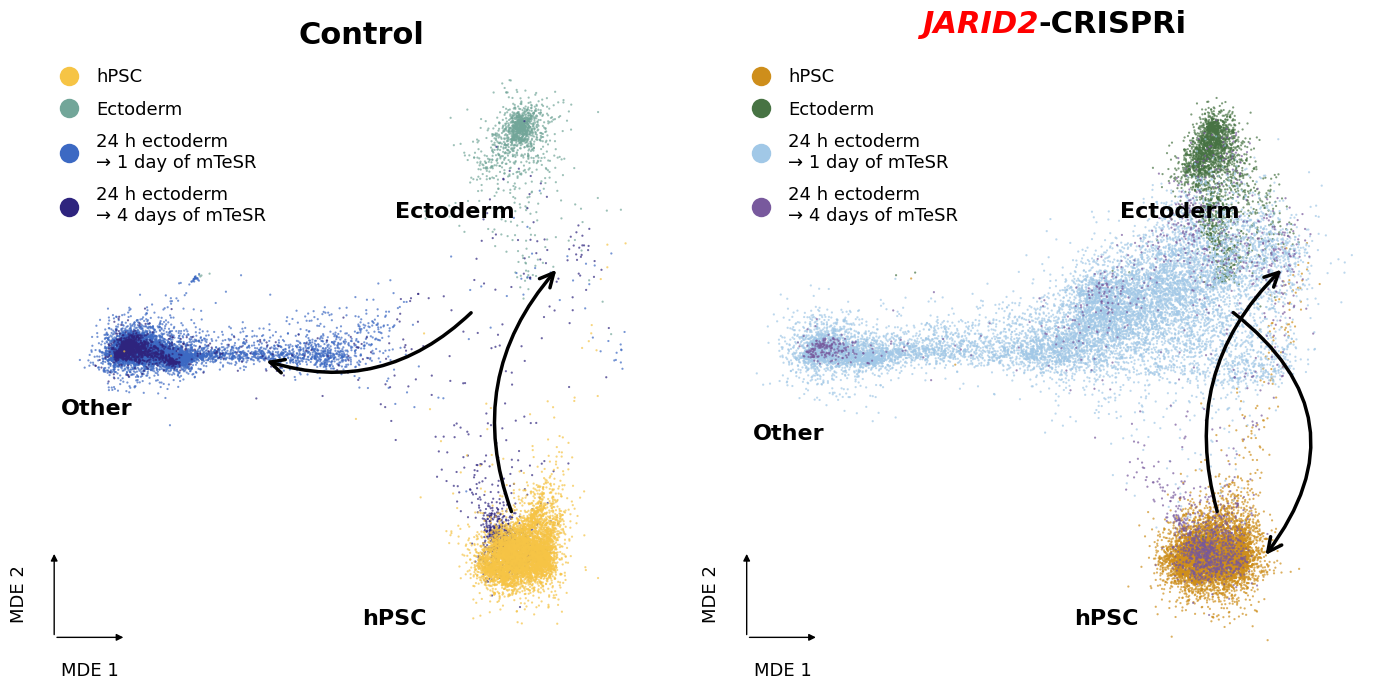

In [5]:
# =================== SWITCHES ===================
DRAW_BENT_ARROWS = True   # Toggle trajectory arrows & cluster labels
# ================================================

# ---- Bent arrow configs (axes fraction) ----
ctrl_bent_arrows = [
    ((0.73, 0.25), (0.80, 0.65), -0.3),   # hPSC -> Ectoderm
    ((0.67, 0.58), (0.35, 0.50), -0.3),   # Ectoderm -> Other
]
jarid2_bent_arrows = [
    ((0.75, 0.25), (0.85, 0.65), -0.3),   # hPSC -> Ectoderm
    ((0.77, 0.58), (0.82, 0.18), -0.5),   # Ectoderm -> hPSC (reversion)
]

ctrl_cluster_labels = [
    ('hPSC',      (0.55, 0.08), 'center'),
    ('Ectoderm',  (0.55, 0.74), 'left'),
    ('Other',     (0.04, 0.42), 'left'),
]
jarid2_cluster_labels = [
    ('hPSC',      (0.58, 0.08), 'center'),
    ('Ectoderm',  (0.60, 0.74), 'left'),
    ('Other',     (0.04, 0.38), 'left'),
]

# Prepare data
data = pd.DataFrame(adata2.obsm['X_mde'], columns=['MDE_1', 'MDE_2'])
data['Sample'] = adata2.obs['sample'].astype(str).tolist()
data['Condition'] = data['Sample'].map(legend_lut)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# Remove spines from both panels
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(''); ax.set_ylabel('')

# --- Left panel: Control ---
data_ctrl = data[data['Sample'].isin(ctrl_samples)].copy()
ctrl_draw_order = ['Ectoderm',
                   '24 h ectoderm\n\u2192 1 day of mTeSR',
                   '24 h ectoderm\n\u2192 4 days of mTeSR',
                   'hPSC']   # hPSC drawn last = on top
data_ctrl['_order'] = data_ctrl['Condition'].map({c: i for i, c in enumerate(ctrl_draw_order)})
data_ctrl = data_ctrl.sort_values('_order')

sns.scatterplot(data=data_ctrl, x='MDE_1', y='MDE_2', hue='Condition',
                palette=ctrl_cond_colors, s=2, alpha=0.7, edgecolor=None,
                hue_order=cond_order, legend=False, ax=ax1, rasterized=True)
ax1.set_title('Control', fontsize=22, fontweight='bold')

ctrl_handles = [Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=ctrl_cond_colors[c],
                       markeredgecolor='none',
                       markersize=14, alpha=1.0)
                for c in cond_order]
ax1.legend(handles=ctrl_handles, labels=cond_order,
           loc='upper left', frameon=False, fontsize=13,
           handletextpad=0.5, labelspacing=0.8)

# --- Right panel: JARID2-CRISPRi ---
data_jarid2 = data[data['Sample'].isin(jarid2_samples)].copy()
data_jarid2['_order'] = data_jarid2['Condition'].map({c: i for i, c in enumerate(cond_order)})
data_jarid2 = data_jarid2.sort_values('_order')

sns.scatterplot(data=data_jarid2, x='MDE_1', y='MDE_2', hue='Condition',
                palette=jarid2_cond_colors, s=2, alpha=0.7, edgecolor=None,
                hue_order=cond_order, legend=False, ax=ax2, rasterized=True)

t1 = TextArea("JARID2", textprops=dict(color="red", fontstyle="italic",
              fontsize=22, fontweight='bold'))
t2 = TextArea("-CRISPRi", textprops=dict(color="black",
              fontsize=22, fontweight='bold'))
title_box = HPacker(children=[t1, t2], pad=0, sep=0)
anchored_title = AnchoredOffsetbox(loc='lower center', child=title_box,
                                    pad=0, frameon=False,
                                    bbox_to_anchor=(0.5, 1.01),
                                    bbox_transform=ax2.transAxes)
ax2.add_artist(anchored_title)

jarid2_handles = [Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=jarid2_cond_colors[c],
                         markeredgecolor='none',
                         markersize=14, alpha=1.0)
                  for c in cond_order]
ax2.legend(handles=jarid2_handles, labels=cond_order,
           loc='upper left', frameon=False, fontsize=13,
           handletextpad=0.5, labelspacing=0.8)

# --- Bent trajectory arrows & cluster labels ---
if DRAW_BENT_ARROWS:
    for ax, arrows, labels in [(ax1, ctrl_bent_arrows, ctrl_cluster_labels),
                                (ax2, jarid2_bent_arrows, jarid2_cluster_labels)]:
        for (start, end, rad) in arrows:
            ax.annotate('', xy=end, xytext=start,
                        xycoords='axes fraction', textcoords='axes fraction',
                        arrowprops=dict(arrowstyle='->', mutation_scale=25,
                                        lw=2.5, color='black',
                                        connectionstyle=f'arc3,rad={rad}'))
        for (text, xy, ha) in labels:
            ax.text(xy[0], xy[1], text, transform=ax.transAxes,
                    fontsize=16, fontweight='bold', ha=ha, va='center')

# --- MDE axis indicator ---
for ax in [ax1, ax2]:
    origin = (0.03, 0.05)
    ax.annotate('', xy=(0.14, 0.05), xytext=origin,
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.0))
    ax.text(0.085, 0.01, 'MDE 1', transform=ax.transAxes,
            ha='center', va='top', fontsize=13)
    ax.annotate('', xy=(0.03, 0.19), xytext=origin,
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.0))
    ax.text(-0.01, 0.12, 'MDE 2', transform=ax.transAxes,
            ha='right', va='center', fontsize=13, rotation=90)

plt.tight_layout()
plt.savefig('figures/Figure2.Samples.MDEmap.pdf', dpi=300, bbox_inches='tight')
plt.show()